In [2]:
import bayes3d as b
from bayes3d.viz.open3dviz import Open3DVisualizer
import os
import jax.numpy as jnp
import open3d as o3d
import jax
import bayes3d.genjax
from tqdm import tqdm
import genjax

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [4]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
obj_idx = 4
mesh_filename = os.path.join(model_dir,"obj_" + "{}".format(obj_idx+1).rjust(6, '0') + ".ply")
SCALING_FACTOR = 1.0/1000.0

In [6]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [10]:
object_poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 0.6, 0.6]),
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)  for angle in jnp.linspace(-jnp.pi, jnp.pi, 7)[:-1]])
observations = b.RENDERER.render_many(object_poses[:,None,...], jnp.array([0]))

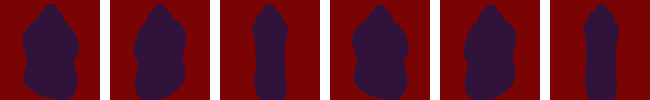

In [13]:
b.hstack_images([b.get_depth_image(o[...,2]) for o in observations])

In [18]:
grid = b.utils.make_translation_grid_enumeration_3d(
    -0.1, -0.1, -0.2,
    0.1, 0.1, 0.2,
    # 100, 100, 100
    60, 60, 60
)
b.show_cloud("grid", grid)

In [19]:
def voxel_occupied_occluded_free(camera_pose, depth_image, grid, intrinsics, tolerance):
    grid_in_cam_frame = b.apply_transform(grid, b.t3d.inverse_pose(camera_pose))
    pixels = b.project_cloud_to_pixels(grid_in_cam_frame, intrinsics).astype(jnp.int32)
    valid_pixels = (0 <= pixels[:,0]) * (0 <= pixels[:,1]) * (pixels[:,0] < intrinsics.width) * (pixels[:,1] < intrinsics.height)
    real_depth_vals = depth_image[pixels[:,1],pixels[:,0]] * valid_pixels + (1 - valid_pixels) * (intrinsics.far + 1.0)
    
    projected_depth_vals = grid_in_cam_frame[:,2]
    occupied = jnp.abs(real_depth_vals - projected_depth_vals) < tolerance
    occluded = real_depth_vals < projected_depth_vals
    occluded = occluded * (1.0 - occupied)
    free = (1.0 - occluded) * (1.0 - occupied)
    return 1.0 * occupied + 0.5 * occluded
voxel_occupied_occluded_free_parallel = jax.jit(jax.vmap(voxel_occupied_occluded_free, in_axes=(0, 0, None, None, None)))

In [20]:
occupancies = voxel_occupied_occluded_free_parallel(
    b.inverse_pose(object_poses), observations[...,2], grid, intrinsics, 0.001
)
print(occupancies.sum())

87440.0


In [21]:
b.clear()
b.show_cloud("grid", grid[(occupancies > 0.6).sum(0) > 0 ])
# b.show_cloud("grid2", grid[occupancy == 0.5],color=b.RED)

In [11]:
mesh = b.utils.make_voxel_mesh_from_point_cloud(grid[(occupancies > 0.6).sum(0) > 0 ], 0.005 )

In [12]:
b.clear()
b.show_trimesh("mesh", mesh)

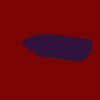

In [22]:
key = jax.random.PRNGKey(10)
random_pose = b.distributions.gaussian_vmf_jit(
    key,
    b.transform_from_pos(jnp.array([0.0, 0.0, 1.4])),
    0.01,
    0.01
)
observation =  b.RENDERER.render(random_pose[None,...], jnp.array([0]))[...,:3]
b.get_depth_image(observation[...,2])

In [14]:
sample_gaussian_vmf_jit = jax.jit(jax.vmap(
    b.distributions.gaussian_vmf_jit,
    in_axes=(0, None, None, None)
))

In [15]:
@genjax.gen
def single_object_model(variance, outlier_prob, outlier_volume):
    pose = b.genjax.uniform_pose(jnp.array([-10.0,-10.0,-10.0]), jnp.array([10.0,10.0,10.0])) @ "pose"
    rendered = b.RENDERER.render(
        pose[None,...] , jnp.array([0])
    )[...,:3]
    image = b.genjax.image_likelihood(rendered, variance, outlier_prob, outlier_volume) @ "image"
    return rendered

importance_jit = jax.jit(single_object_model.importance)
key = jax.random.PRNGKey(5)
enumerator,enumerator_score, enumerator_vmap, enumerator_vmap_score = b.genjax.make_enumerator(["pose"]) 

In [16]:
trace = importance_jit(
    key,
    genjax.choice_map({"image": observation}),
    (0.001, 0.001, 1000.0)
)[1][1]

In [17]:
keys = jax.random.split(key, 1000)
poses = sample_gaussian_vmf_jit(keys,     b.transform_from_pos(jnp.array([0.0, 0.0, 1.4])),
    0.01,
    0.01)

In [18]:
scores = enumerator_vmap_score(trace, key, poses)

In [ ]:
trace = enumerator(trace, key, poses[scores.argmax()])

In [ ]:
b.clear()
b.show_cloud("obs", trace["image"].reshape(-1,3))
b.show_cloud("render", trace.get_retval().reshape(-1,3), color=b.RED)

In [50]:
keys = jax.random.split(key, 5000)
poses = sample_gaussian_vmf_jit(keys,     b.transform_from_pos(jnp.array([0.0, 0.0, 1.4])),
    0.01,
    0.01)

In [54]:
grid_over_pose = jax.jit(jax.vmap(
    lambda trace,key, p: trace.update(key, genjax.choice_map({"pose": p}), tuple(map(lambda v: Diff(v, UnknownChange), trace.args)))
, in_axes=(None, None, 0))
)

In [55]:
grid_over_pose(trace, key, poses)

NameError: name 'Diff' is not defined

In [7]:
viz = Open3DVisualizer(intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [11]:
viz.clear()
mesh = o3d.io.read_triangle_model(mesh_filename)
mesh.meshes[0].mesh.scale(SCALING_FACTOR, jnp.array([0.0, 0.0, 0.0]))
viz.render.scene.add_model(f"1", mesh)

6it [00:00,  8.18it/s]


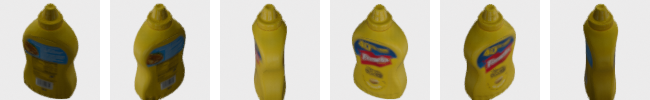

In [12]:
images = []
for i, pose in tqdm(enumerate(object_poses)):
    rgbd = viz.capture_image(intrinsics, b.t3d.inverse_pose(pose))
    images.append(rgbd)
b.hstack_images([b.get_rgb_image(rgbd.rgb) for rgbd in images])